In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchshow as ts
from datasets.nerf_synthetic import SubjectLoader
from matplotlib import pyplot as plt
from nerfacc.estimators.occ_grid import OccGridEstimator
from radiance_fields.ngp import NGPRadianceField
from typing import Any, Dict
from utils import render_image_with_occgrid_test

device = "cuda:0"

# dataset parameters
scene = "drums"
data_root = "/media/data7/fballerini/datasets/nerf_synthetic"
test_dataset_kwargs = {}
# scene parameters
aabb = torch.tensor([-1.5, -1.5, -1.5, 1.5, 1.5, 1.5], device=device)
near_plane = 0.0
far_plane = 1.0e10
# model parameters
grid_resolution = 128
grid_nlvl = 1
# render parameters
render_step_size = 5e-3
alpha_thre = 0.0
cone_angle = 0.0

test_dataset = SubjectLoader(
    subject_id=scene,
    root_fp=data_root,
    split="test",
    num_rays=None,
    device=device,
    **test_dataset_kwargs,
)

estimator = OccGridEstimator(roi_aabb=aabb, resolution=grid_resolution, levels=grid_nlvl).to(device)
radiance_field = NGPRadianceField(aabb=estimator.aabbs[-1], encoding_type="torch").to(device)

In [2]:
def render_test(state_dict: Dict[str, Any]) -> None:
    estimator.load_state_dict(state_dict["estimator"])
    radiance_field.load_state_dict(state_dict["radiance_field"])

    # evaluation
    radiance_field.eval()
    estimator.eval()

    with torch.no_grad():
        data = test_dataset[0]
        render_bkgd = data["color_bkgd"]
        rays = data["rays"]
        pixels = data["pixels"]

        # rendering
        rgb, _, _, _ = render_image_with_occgrid_test(
            1024,
            # scene
            radiance_field,
            estimator,
            rays,
            # rendering options
            near_plane=near_plane,
            render_step_size=render_step_size,
            render_bkgd=render_bkgd,
            cone_angle=cone_angle,
            alpha_thre=alpha_thre,
        )
        mse = F.mse_loss(rgb, pixels)
        psnr = -10.0 * torch.log(mse) / np.log(10.0)
        
        ts.show(rgb)
        return psnr.item()

In [47]:
def scatter_plot(sd_A: Dict[str, Any], sd_B: Dict[str, Any]) -> None:
    fig1, ax1 = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
    fig2, ax2 = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
    for l in range(16):
        H_A_l = sd_A["radiance_field"][f"mlp_base.0.levels.{l}.embedding.weight"].cpu().numpy()
        H_B_l = sd_B["radiance_field"][f"mlp_base.0.levels.{l}.embedding.weight"].cpu().numpy()
        
        x = H_A_l[:, 0]
        y1 = H_B_l[:, 0]
        y2 = H_B_l[:, 1]

        i = l // 4
        j = l % 4

        ax1[i, j].scatter(x, y1, s=5)
        ax2[i, j].scatter(x, y2, s=5)

        ax1[i, j].set_title(f"Level {l}")
        ax2[i, j].set_title(f"Level {l}")
    fig1.tight_layout()
    fig2.tight_layout()
    fig1.suptitle("$x=H_A[:,0],y=H_B[:,0]$")
    fig2.suptitle("$x=H_A[:,0],y=H_B[:,1]$")
    fig1.subplots_adjust(top=0.92)
    fig2.subplots_adjust(top=0.92)
    fig1.show()
    fig2.show()

$A,B$ same shape, diff init

$H$ = multi-resolution hash grid

$M$ = MLP (actually there are two, one for density and one for color)

$(H_A,M_A)$
---

29.27492332458496

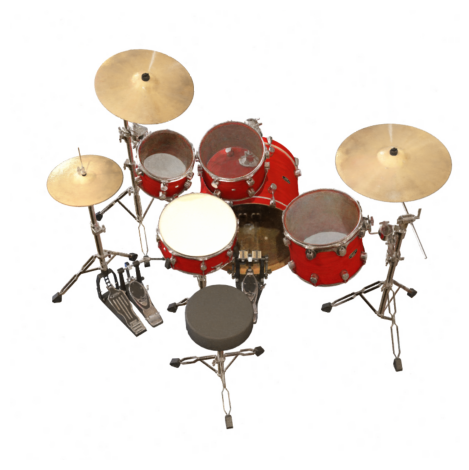

In [48]:
sd_A = torch.load("ckpts/drums_torch_A.pt")

render_test(sd_A)

$(H_B,M_B)$
---

29.252742767333984

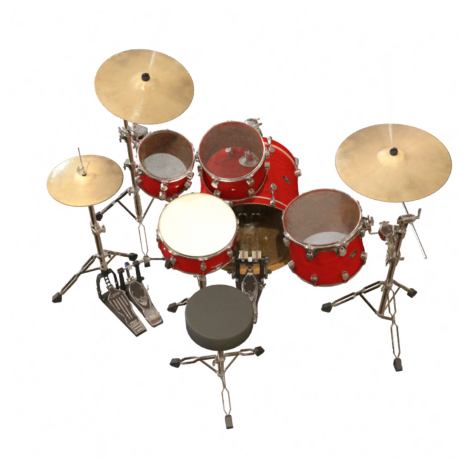

In [49]:
sd_B = torch.load("ckpts/drums_torch_B.pt")

render_test(sd_B)

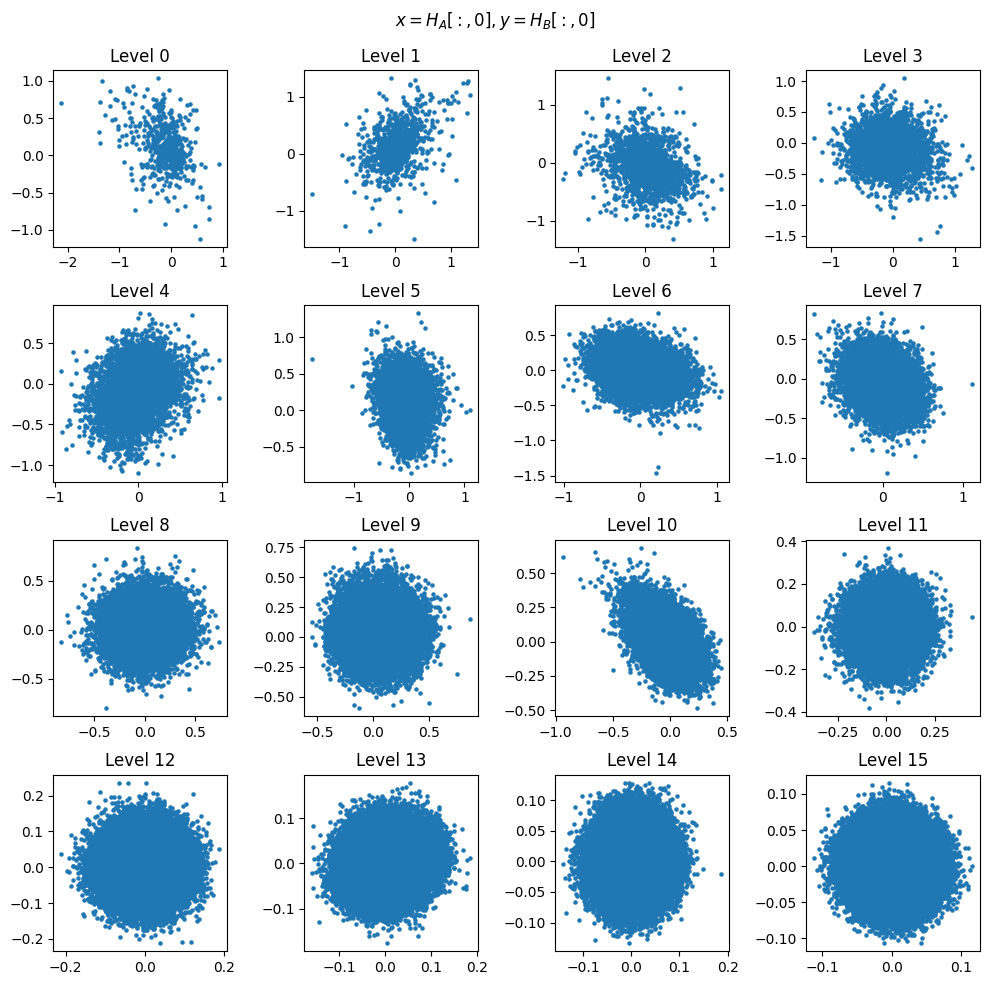

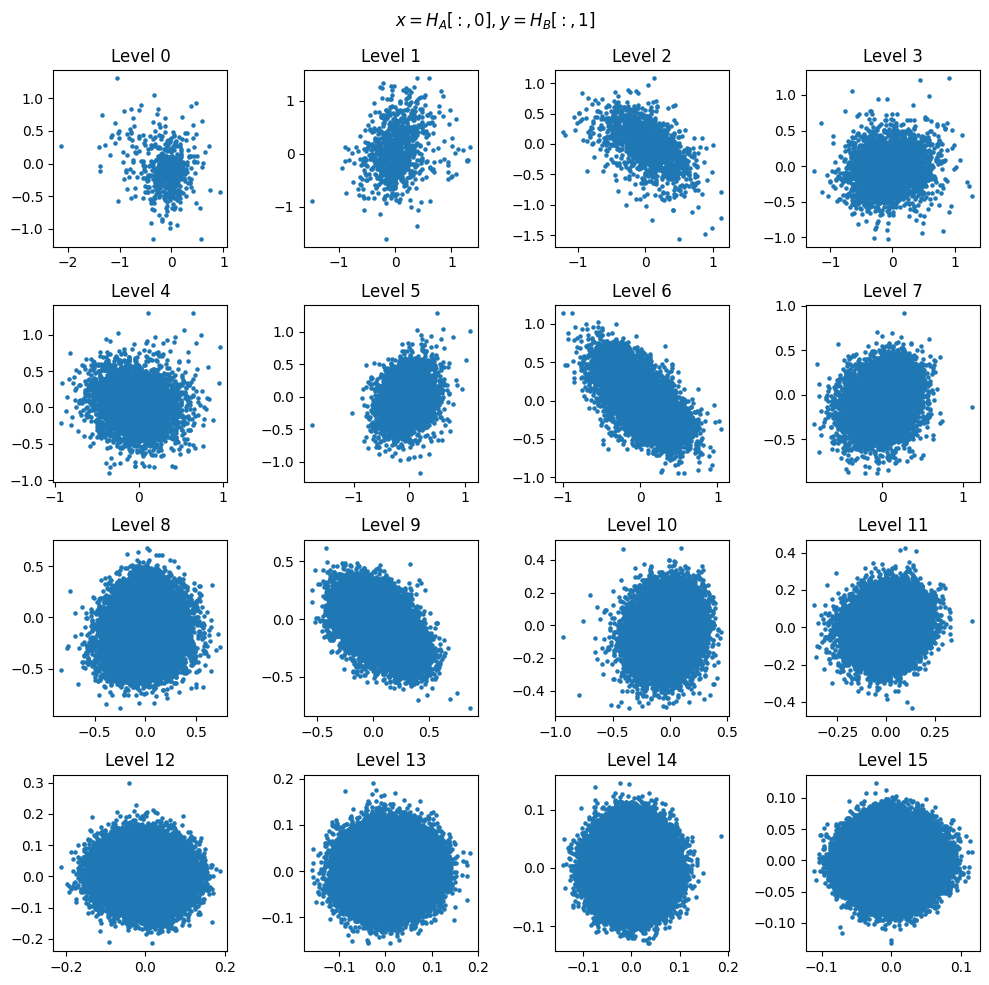

In [50]:
sd_A = torch.load("ckpts/drums_torch_A.pt")
sd_B = torch.load("ckpts/drums_torch_B.pt")

scatter_plot(sd_A, sd_B)

$(H_A,M_B)$
---

11.182065963745117

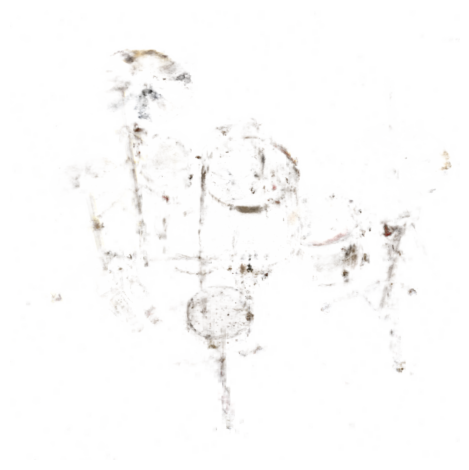

In [51]:
sd_A = torch.load("ckpts/drums_torch_A.pt")
sd_B = torch.load("ckpts/drums_torch_B.pt")
sd_A["radiance_field"]["mlp_base.1.params"] = sd_B["radiance_field"]["mlp_base.1.params"]  # density mlp
sd_A["radiance_field"]["mlp_head.params"] = sd_B["radiance_field"]["mlp_head.params"]  # color mlp

render_test(sd_A)

$(H_A^\text{perm},M_B)$
---

12.416668891906738

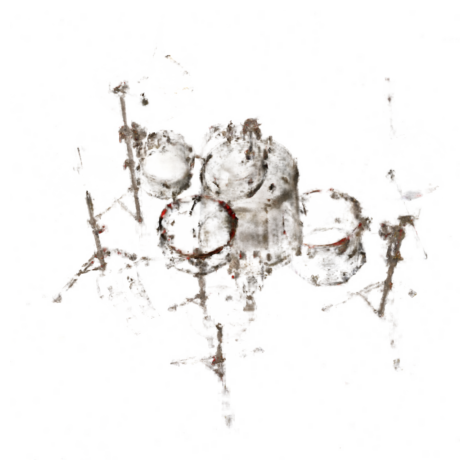

In [52]:
sd = torch.load("ckpts/drums_torch_perm.pt")

render_test(sd)

---

$A,A'$ same shape, same init

$(H_A, M_{A'})$
---

21.0594539642334

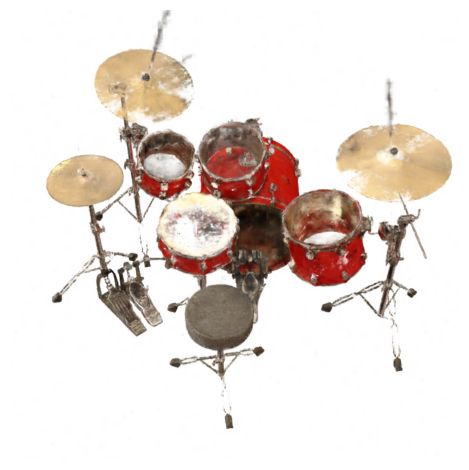

In [54]:
sd_A = torch.load("ckpts/drums_torch_A.pt")
sd_B = torch.load("ckpts/drums_torch_A2.pt")
sd_A["radiance_field"]["mlp_base.1.params"] = sd_B["radiance_field"]["mlp_base.1.params"]  # density mlp
sd_A["radiance_field"]["mlp_head.params"] = sd_B["radiance_field"]["mlp_head.params"]  # color mlp

render_test(sd_A)

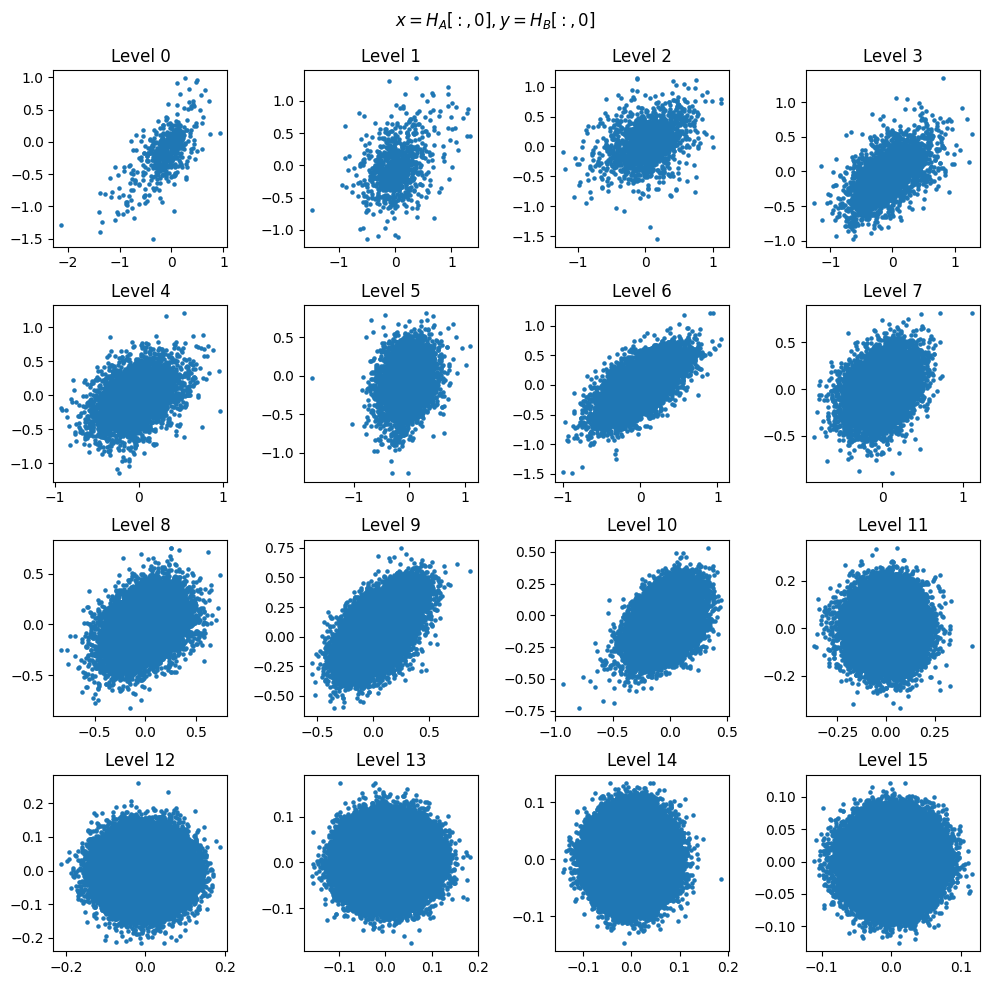

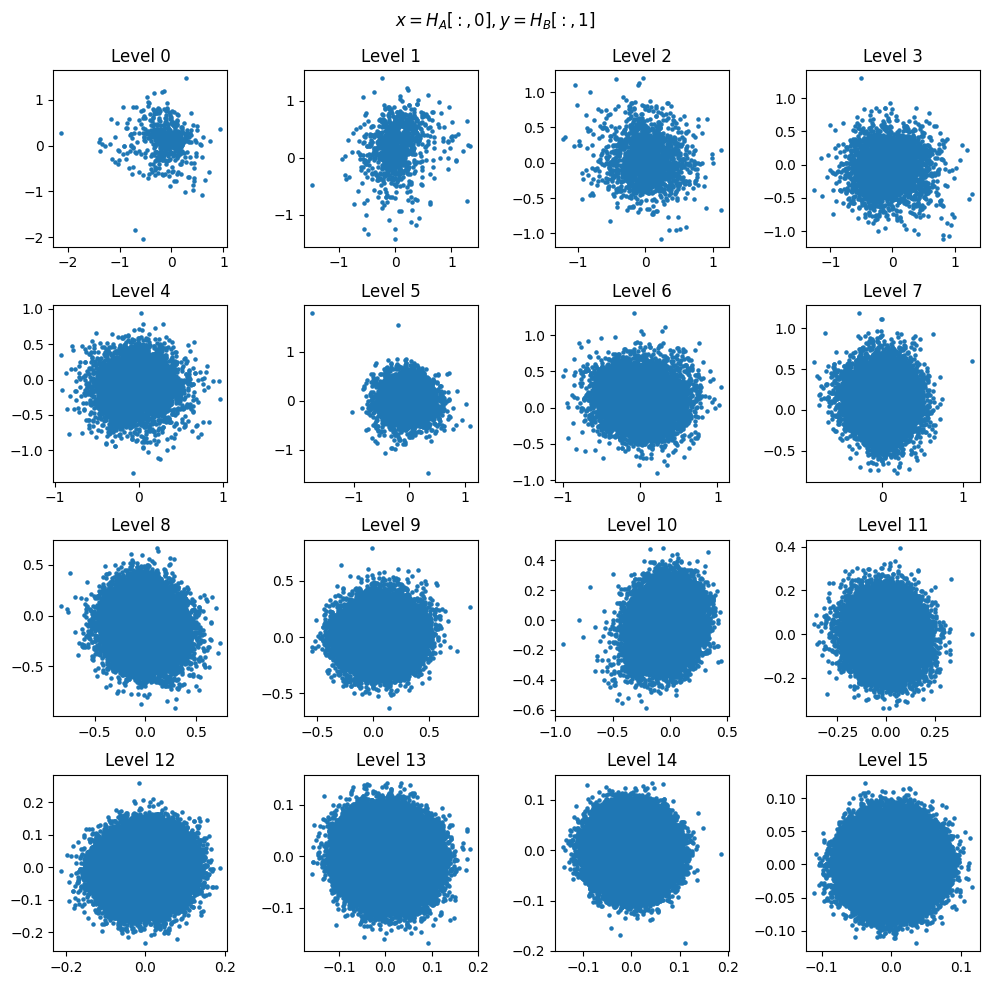

In [55]:
sd_A = torch.load("ckpts/drums_torch_A.pt")
sd_B = torch.load("ckpts/drums_torch_A2.pt")

scatter_plot(sd_A, sd_B)

---

What if $B$ is such that $\text{init}(H_B)=\text{init}(H_A)$ and $\text{init}(M_B)\neq\text{init}(M_A)$?

$(H_B,M_B)$
---

29.239913940429688

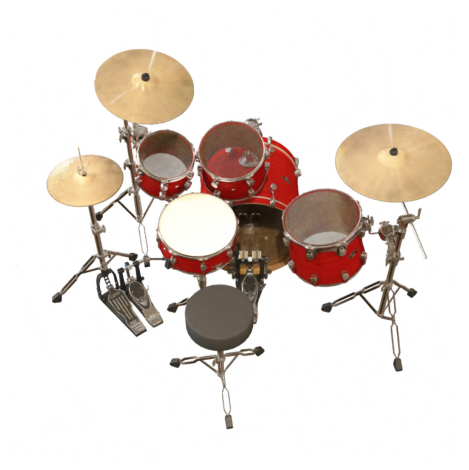

In [56]:
sd_B = torch.load("ckpts/drums_torch_hash_A_mlp_B.pt")

render_test(sd_B)

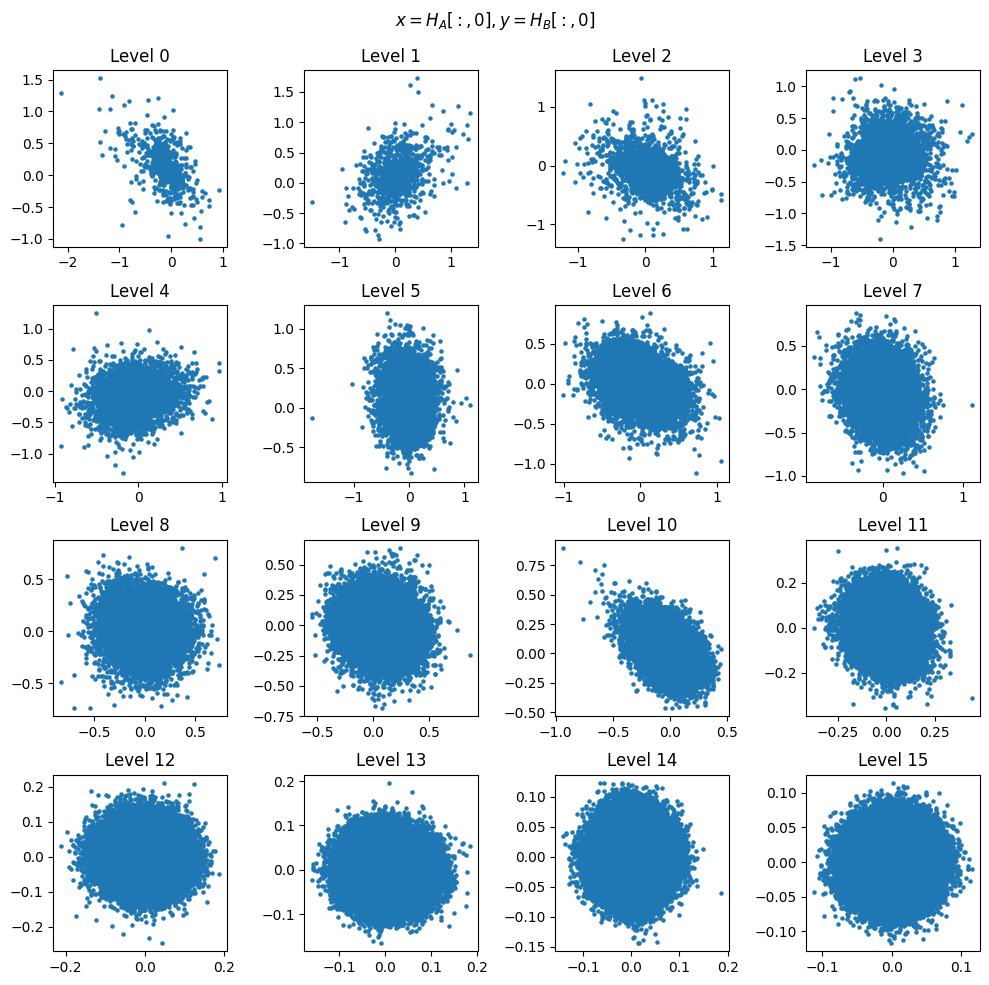

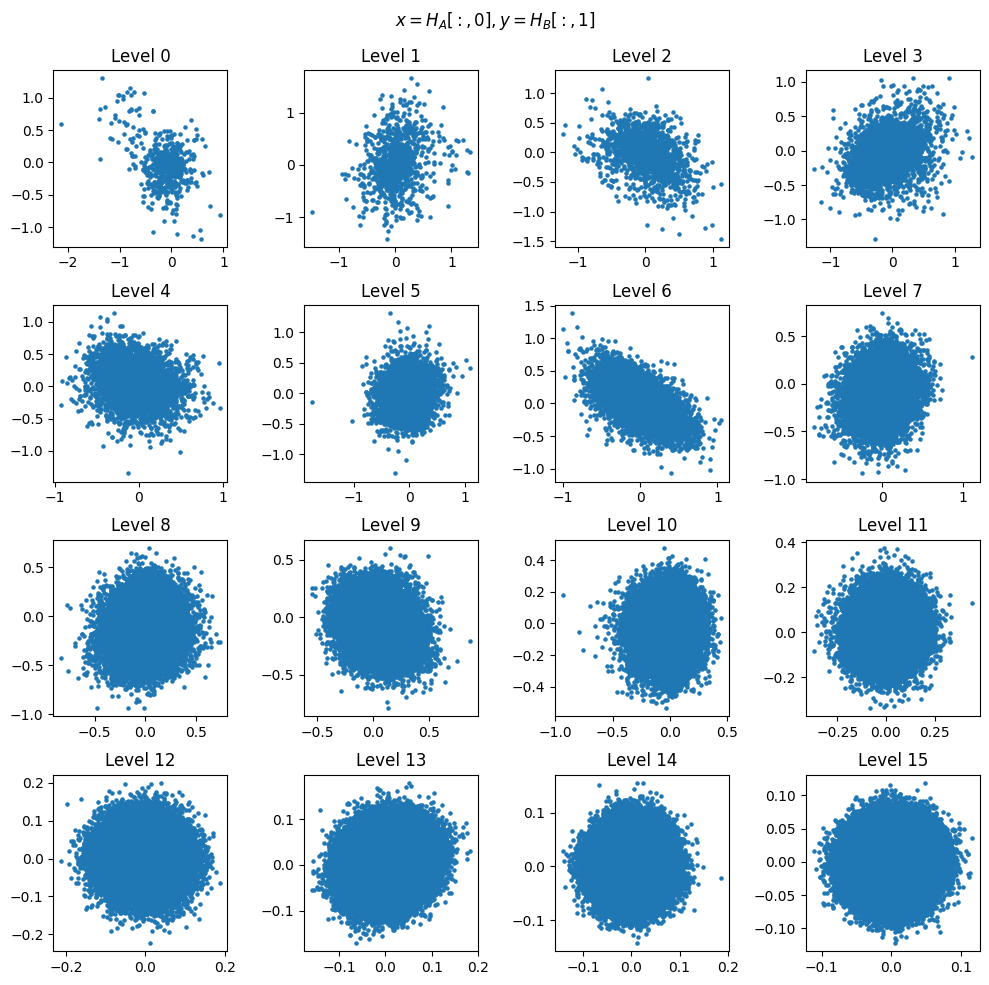

In [57]:
sd_A = torch.load("ckpts/drums_torch_A.pt")
sd_B = torch.load("ckpts/drums_torch_hash_A_mlp_B.pt")

scatter_plot(sd_A, sd_B)

$(H_A,M_B)$
---

11.6387357711792

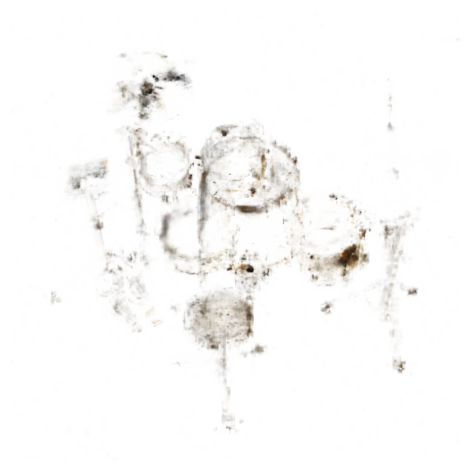

In [58]:
sd_A = torch.load("ckpts/drums_torch_A.pt")
sd_B = torch.load("ckpts/drums_torch_hash_A_mlp_B.pt")
sd_A["radiance_field"]["mlp_base.1.params"] = sd_B["radiance_field"]["mlp_base.1.params"]  # density mlp
sd_A["radiance_field"]["mlp_head.params"] = sd_B["radiance_field"]["mlp_head.params"]  # color mlp

render_test(sd_A)

$(H_A^\text{perm},M_B)$
---

12.766181945800781

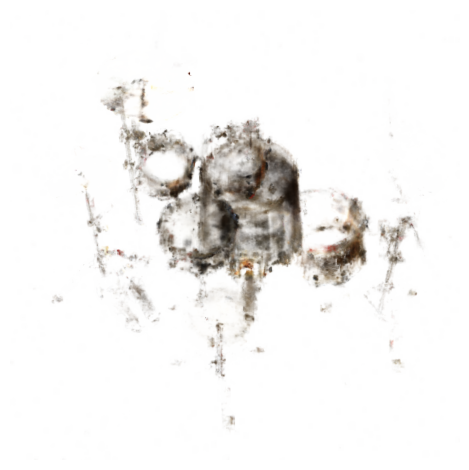

In [59]:
sd = torch.load("ckpts/drums_torch_perm_v2.pt")

render_test(sd)